In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

using Plots
using Random
using Parameters
using Printf
using DataFrames
using StatsPlots
using Distances
using LinearAlgebra
using Memoization
using Symbolics

using StatsPlots
using HypothesisTests

using Base.Threads
using Base.Threads: @spawn

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))
df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

┌ Info: Scanning folder /Users/boothh/Documents/GRNEvoContingency/data/sims/repeated_evolution_different_topologies for result files.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:115
┌ Info: Added 8 entries.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:191


In [3]:
headings = ["topology",
            "target",
            "n_traj",
            "max_gen",
            "β",
            "noise_cv",
            "mutation_method",
            "noise_method",
            "n_max_iters_reached",
            "describe_proportion_mutants_rejected"];

df[:,headings]

Row,topology,target,n_traj,max_gen,β,noise_cv,mutation_method,noise_method,n_max_iters_reached,describe_proportion_mutants_rejected
,String?,Array…?,Int64?,Int64?,Float64?,Float64?,String?,String?,Int64?,SummaryS…?
1,classical,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.018348\nMinimum: 0.001850\n1st Quartile: 0.012676\nMedian: 0.016801\n3rd Quartile: 0.020967\nMaximum: 0.075696\n
2,feed_forward,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.019802\nMinimum: 0.000000\n1st Quartile: 0.000669\nMedian: 0.012043\n3rd Quartile: 0.035063\nMaximum: 0.097395\n
3,mutual_inh,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.020275\nMinimum: 0.001313\n1st Quartile: 0.017634\nMedian: 0.020514\n3rd Quartile: 0.023056\nMaximum: 0.032863\n
4,overlap_dom,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.012762\nMinimum: 0.000000\n1st Quartile: 0.000366\nMedian: 0.004846\n3rd Quartile: 0.017632\nMaximum: 0.240788\n
5,classical,"[(40.0, 20.0)]",2500,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 2500\nMissing Count: 0\nMean: 0.022178\nMinimum: 0.000000\n1st Quartile: 0.000000\nMedian: 0.004796\n3rd Quartile: 0.028302\nMaximum: 0.560301\n
6,feed_forward,"[(40.0, 20.0)]",2500,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 2500\nMissing Count: 0\nMean: 0.156745\nMinimum: 0.000000\n1st Quartile: 0.089655\nMedian: 0.128423\n3rd Quartile: 0.194289\nMaximum: 0.897805\n
7,mutual_inh,"[(40.0, 20.0)]",2500,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 2500\nMissing Count: 0\nMean: 0.109172\nMinimum: 0.000000\n1st Quartile: 0.050000\nMedian: 0.084526\n3rd Quartile: 0.126080\nMaximum: 0.836708\n
8,overlap_dom,"[(40.0, 20.0)]",2500,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 2500\nMissing Count: 0\nMean: 0.206376\nMinimum: 0.000000\n1st Quartile: 0.126624\nMedian: 0.193882\n3rd Quartile: 0.266872\nMaximum: 0.725014\n


In [4]:
df_current = filter(:n_traj=>x->x==2500,df);

In [5]:
evolutionary_runs = Dict{String,Any}("classical"=>df_current[:,"raw_data"][1],"feed_forward"=>df_current[:,"raw_data"][2],"mutual_inh"=>df_current[:,"raw_data"][3],"overlap_dom"=>df_current[:,"raw_data"][4]);

In [6]:
topology = "overlap_dom"
start_network = example_networks[topology]
run_data = evolutionary_runs[topology];

In [10]:
# a = Vector{Tuple{Float64,Float64}}()
# push!(a,(1.,1.))

In [11]:
w_vec(w) = reverse(vec(Int.(sign.(w) .+ 1)))
vec_b3(v) = foldl((x,y) -> 3*x+y, v)

w_b3(w) = vec_b3(w_vec(w))

w_b3 (generic function with 1 method)

Check mutation prob e.g. for (2,1) there are improvement points but zero prob

In [13]:
traversed_networks =  map(x->unique(x[2].traversed_topologies),run_data)
end_networks = map(x->unique(x[2].traversed_topologies)[end],run_data);
end_networks_label = map(x->w_b3(x),end_networks)
first_mutation = map(x->findall(abs.(x[2] .- x[1]) .> 0), traversed_networks);
first_mutation_v = reduce(vcat,first_mutation);

In [14]:
results = DataFrame(First_mut = first_mutation_v,EndTop = end_networks_label)

Row,First_mut,EndTop
,Cartesia…,Int64
1,"CartesianIndex(2, 1)",284155
2,"CartesianIndex(2, 3)",289285
3,"CartesianIndex(3, 2)",291471
4,"CartesianIndex(2, 1)",284829
5,"CartesianIndex(3, 2)",282642
6,"CartesianIndex(1, 3)",282697
7,"CartesianIndex(3, 2)",278296
8,"CartesianIndex(1, 3)",282697
9,"CartesianIndex(1, 4)",288556


In [15]:
countmap(results[:,:First_mut])

Dict{CartesianIndex{2}, Int64} with 9 entries:
  CartesianIndex(2, 3) => 119
  CartesianIndex(2, 1) => 284
  CartesianIndex(1, 3) => 582
  CartesianIndex(1, 1) => 72
  CartesianIndex(1, 4) => 343
  CartesianIndex(3, 1) => 347
  CartesianIndex(2, 2) => 54
  CartesianIndex(1, 2) => 44
  CartesianIndex(3, 2) => 655

In [31]:
function get_end_distributions(entry,results)
    df = filter(:First_mut=>x->x==entry,results)
    total = size(df,1)
    r = map(x->x[2],sort(collect(countmap(df[:,:EndTop])),by=x->x[2],rev = true))

    return cumsum(r)
end

function get_end_top(entry,results)
    df = filter(:First_mut=>x->x==entry,results)
    total = size(df,1)
    # r = sort(collect(countmap(df[:,:EndTop])),by=x->x[2],rev = true)

    r = df[:,:EndTop]

    return r
end

get_end_top (generic function with 1 method)

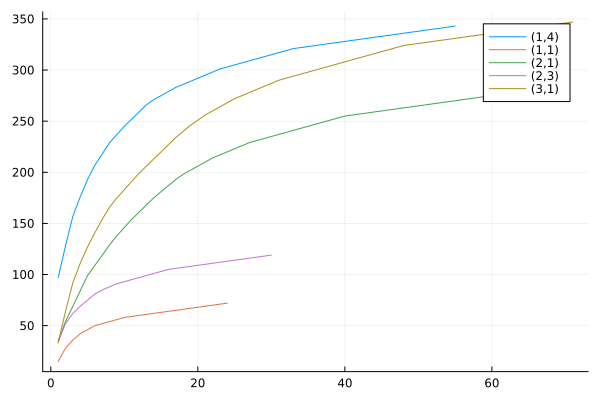

In [32]:
f = plot(get_end_distributions(CartesianIndex(1,4),results),label = "(1,4)")
plot!(f,get_end_distributions(CartesianIndex(1,1),results),label = "(1,1)")
plot!(f,get_end_distributions(CartesianIndex(2,1),results),label = "(2,1)")
plot!(f,get_end_distributions(CartesianIndex(2,3),results),label = "(2,3)")
plot!(f,get_end_distributions(CartesianIndex(3,1),results),label = "(3,1)")


In [35]:
matrix_entries = [(1,1),(2,1),(3,1),(1,2),(2,2),(3,2),(1,3),(2,3),(3,3),(1,4),(2,4),(3,4)];

w = zeros(12,12)

for i in 1:length(matrix_entries)
    for j in 1:length(matrix_entries)
        w[i,j] = length(intersect(Set(get_end_top(CartesianIndex(matrix_entries[i]...),results)),Set(get_end_top(CartesianIndex(matrix_entries[j]...),results)))) / length(Set(get_end_top(CartesianIndex(matrix_entries[i]...),results)))
    end
end

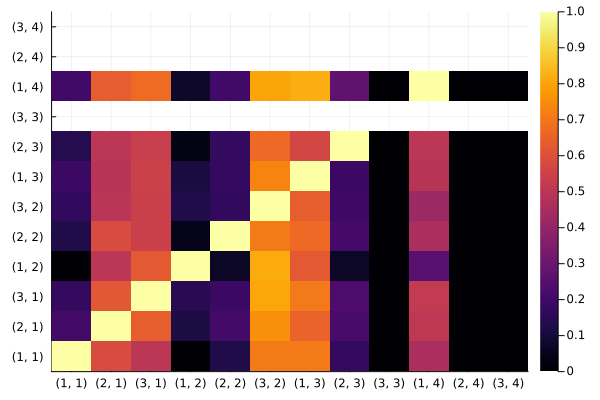

In [39]:
heatmap(w, xticks = (1:12,matrix_entries),yticks = (1:12,matrix_entries))

In [ ]:
w_vec(w) = reverse(vec(Int.(sign.(w) .+ 1)))
vec_b3(v) = foldl((x,y) -> 3*x+y, v)

w_b3(w) = vec_b3(w_vec(w))

function find_topology_changes(traversed_networks::Vector{Matrix{Float64}})

    traversed_topologies = map(n->w_b3(n),traversed_networks)

    current_top = traversed_topologies[1]

    topology_changes = zeros(length(traversed_topologies))

    for top_id in 1:length(traversed_topologies)
        if traversed_topologies[top_id] != current_top
            topology_changes[top_id] = 1
            current_top = traversed_topologies[top_id]
        end
    end

    return topology_changes
end   

In [ ]:
aa = map(x->isnan(x) ? Inf : x,reduce(hcat,map(x->vec(x.angles),ll_traj_uni)))

In [ ]:
ta = map(x->x==0 ? Inf : x,find_topology_changes(unique(run_data[2][2].traversed_topologies)))

In [ ]:
f = plot(aa[1,:],size = (2000,1000),label = matrix_entries[1],color = colors[matrix_entries[1]])

for i in 2:12
    plot!(f,aa[i,:],color = colors[matrix_entries[i]],label = matrix_entries[i],legend =  :outerleft)
end

scatter!(ta,label = "Topology change")

f